# Test Classification

In [1]:
import snxform
from snxform import io, preproc
from snxform.network import ViT

import numpy as np
import matplotlib.pyplot as plt

import os
from urllib import request
import json
import torch

## Initialize PyTorch Model

Load a `ViT` model from `snxform.network` using previously trained weights.

In [2]:
torch.manual_seed(4);

paramfile = os.path.join(snxform.src_path, 'etc/vit_model_V2_parameters.json')

with open(paramfile, 'r') as f:
    modelpars = json.load(f)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = ViT(
    cl=modelpars['cl'], 
    n_patches=modelpars['patches'], 
    n_blocks=modelpars['n_blocks'], 
    hidden_d = modelpars['hidden_d'],
    n_heads = modelpars['n_heads'],
    out_d = 6).to(device)

statefile = '/global/homes/s/sybenzvi/desi/spectra_nn/desiWorkflow/v2/model/vit_model_V2_epoch26.pt'
# statefile = os.path.join(snxform.src_path, 'etc/vit_model_V2_epoch26.pt')

model_state_dict = torch.load(statefile, map_location=device)
state = model.load_state_dict(model_state_dict)
print(f'{state}, model loaded')

ViT IS NOW IN cuda
<All keys matched successfully>, model loaded


## Read Spectra

This will read some spectra, applying basic target selection to get (primarily) BGS galaxies.

In [20]:
cspectra = io.read_desi_spectra('/global/cfs/cdirs/desi/spectro/redux/daily/tiles/cumulative/22522/20211023/spectra-6-22522-thru20211023.fits')

INFO:spectra.py:391:read_spectra: iotime 0.510 sec to read spectra-6-22522-thru20211023.fits at 2024-05-21T06:23:08.153390


In [21]:
#- Extract the data
wave = cspectra.wave['brz']
flux = cspectra.flux['brz']
ivar = cspectra.ivar['brz']

fmap = cspectra.fibermap
expfmap = cspectra.exp_fibermap

In [22]:
#- Clean sky lines and rebin.
newflux = preproc.remove_sky_lines(wave, flux, ivar)
newwave, newflux, newivar = preproc.rebin_flux(wave, newflux, ivar, nbins=3600)

#- Rescale the flux (not strictly necessary).
flux_rescaled = preproc.rescale_flux(newflux)

## Apply Model Predictions

Convert the data into a tensor and apply the model prediction.
The output is a PyTorch `Tensor` containing the categorical probability that a given flux is a galaxy, SN Ia, etc.

In [23]:
def predict_data(model, flux, device):
    model.eval()
    
    if flux.ndim == 2:
        m, n = flux_rescaled.shape
        x = torch.Tensor(np.reshape(flux, (m, 1, n)))
    elif flux.ndim == 3:
        x = torch.Tensor(flux)
    else:
        raise ValueError('Flux needs to be of shape (m,1,n)')
    
    with torch.no_grad():
        x.to(device)
        output = model(x)
    
    return output

y_pred = predict_data(model, flux_rescaled, device)
y_val = y_pred.detach().cpu().numpy()

In [24]:
#- Extract the category predicted by the network.
i = np.argmax(y_val, axis=1)

#- Compute the max categorical probability for each prediction.
y_max = np.max(y_val, axis=1)

#- Select non-galaxy predictions where the network is confident.
select = (i == 1) & (y_max > 0.999)
fmap['TARGETID'][select]

39633321356951680


## Plot the Selections

The results should contain some transients.

There may be false positives where the continuum fools the network.

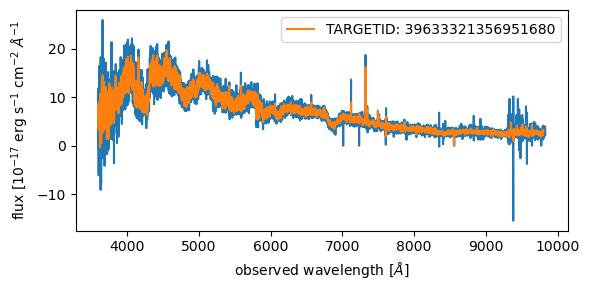

In [25]:
N = np.sum(select)
idx_sne = np.argwhere(select).flatten()

fig, axes = plt.subplots(N, 1, figsize=(6, 3*N), sharex=True, tight_layout=True)
for j, i_sn in enumerate(idx_sne):
    
    if N > 1:
        ax = axes[j]
        if j == 0:
            ax.set(ylabel=r'flux [$10^{-17}$ erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$')
        elif j == N-1:
            ax.set(xlabel=r'observed wavelength [$\AA$]')
    else:
        ax = axes
        ax.set(xlabel=r'observed wavelength [$\AA$]',
               ylabel=r'flux [$10^{-17}$ erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$')
        
    ax.plot(wave, flux[i_sn])
    ax.plot(newwave, newflux[i_sn], label=f'TARGETID: {fmap["TARGETID"][i_sn]}')
    ax.legend(loc='best')